# The particle *-nya* in Indonesian: a possessive suffix or an anaphoric pronoun?

# Setting the scene
This project aims at studying the **selectional syntactic patterns** of the particle *-nya* in Indonesian. In Indonesian grammars (Sneddon 1996, Ogloblin 2008), the particle *-nya* is claimed to be a third person possessive marker; this function of the particle is exemplified in (1) below. However, the particle *-nya* has another function, which is, apparently, undocumented in grammars: it can be used as an anaphoric pronoun meaning 'it, this one'. This function is exemplified in (2): in this example, the particle *-nya* means 'it'/'this thing'.



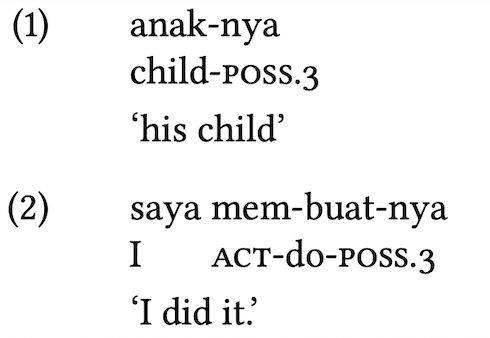

This study aims at answering the following research questions:


1.   How productive is the anaphoric usage of *-nya*? In other words, **how often the particle *-nya* combines with verbs (compared to other categories)**? 
2.   Is it true that, over time, the particle *-nya* attaches to verbs (i.e. is used as an anaphoric pronoun) **more often**? In other words, is it true that the particle *-nya* **undergoes grammaticalization and acquires a new function**? (See Haspelmath 1999 on the correlation between frequency of use and grammaticalization).
  
  2.1. Is it true that there is a difference between spoken and written language in that respect?





To answer those questions, I will:


*   Automatically download a small collection of today's texts from an Indonesian newspaper, [republika.co.id](https://republika.co.id)
*   Load two additional sources of data: a translation of Bible from 1912, and a collection of spoken texts from [Indoneisan frog story corpus](https://github.com/davidmoeljadi/corpus-frog-storytelling).
* cleanse the texts
* write a simple Part-Of-Speech morphological analyzer, which distinguishes Indonesian verbs from non-verbs
* count how often *-nya* is attached to verbs and to non-verbs, and visualize the results
* do some basic statistical testing, to know whether the difference between different kinds of texts is significant or not



# Retrieving Indonesian texts from the Web

In [106]:
import urllib.request
import requests
import re
import os
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from scipy.stats import chisquare

Below is the function which collects all the links which lead to an actual news page from a given page:

In [3]:
def get_links(page_address):
  main_page_raw = urllib.request.urlopen(page_address).read().decode("ISO-8859-1")
  main_page = BeautifulSoup(main_page_raw,"lxml")
  links = [link for link in [link.get('href') for link in main_page.findAll('a')] if re.match(r"https://www.republika.co.id/berita/.",str(link))]
  return links

Now, let us get all the relevant texts from from the page https://republika.co.id/kanal/news, cleanse it and write down to a .txt file.

In [4]:
def cleanse(text):
    exclude = ",{}“”*%<>@—:;\"\'()[]+=^~#…&—`123456789-«»0!?.\xa0\t"
    no_orpho = [symb for symb in text if not symb in exclude]
    return "".join(no_orpho).lower() 

def get_page_text(adrs):
  html = requests.get(adrs)
  htmlParse = BeautifulSoup(html.content, 'html.parser')
  artikel = htmlParse.find_all("p")
  selected = cleanse(" ".join([item.get_text() for item in artikel[5:-25]]))
  return selected

In [ ]:
rep_news = "https://republika.co.id/kanal/news"
links = get_links(rep_news)
republika_text = ""


for link in links:
  republika_text = republika_text + " " + get_page_text(link)

with open("republika_corp.txt","w+",encoding="UTF-8") as f:
  f.write(republika_text)

#print(republika_text)

https://www.republika.co.id/berita/r3squh436/firli-disarankan-hadiri-pelantikan-eks-pegawai-kpk-jadi-asn-polri
https://www.republika.co.id/berita/r3sqmq384/ini-klarifikasi-kemenkes-terkait-kabar-masuknya-varian-omicron
https://www.republika.co.id/berita/r3sooh487/ppkm-level-3-nataru-diumumkan-muhadjir-dibatalkan-luhut-dijelaskan-tito
https://www.republika.co.id/berita/r3sms7282/pengamen-todong-penumpang-angkot-di-bogor-polisi-buru-pelaku
https://www.republika.co.id/berita/r3sl75436/delapan-fraksi-setuju-ruu-tpks-jadi-inisiatif-dpr
https://www.republika.co.id/berita/r3sq37282/gubes-politik-upi-jika-dipasangkan-prabowopuan-leading-tapi
https://www.republika.co.id/berita/r3sm85349/ppp-minta-pemerintah-genjot-kebijakan-ekonomi-hijau
https://www.republika.co.id/berita/r3sl75436/delapan-fraksi-setuju-ruu-tpks-jadi-inisiatif-dpr
https://www.republika.co.id/berita/r3sk73487/pks-tak-setuju-ruu-tpks-disahkan-selama-zina-dan-lgbt-juga-tidak-dilarang
https://www.republika.co.id/berita/r3sieq436/fr

#The parser function

Let us make a hand-made Indonesian Part Of Speech parser. The only goal of the parser is to distinguish nominal categories from non-nominal ones.

In [5]:
verb_pref = ["me","ber","di","ku","saya"]
exceptions = ["mereka", "merdeka","merpagi"] # some apparent exceptions: word that start with me- but are not verbs. 
# the list is to be continues

In [59]:
def is_verb(word):
  for pref in verb_pref:
    if word.startswith(pref) and not word in exceptions:
      return True
  return False

# Counting 
Now we'll load the three sources of data: the Bible, the news from Republika, and the spoken texts.

In [90]:
standard_corp = ""
spoken_corp = ""
bible_corp = ""


with open("republika_corp.txt","r",encoding="UTF-8") as f:
  standard_corp = [word for word in f.read().split() if len(word) > 1]

with open("speaking_all_speakers.txt","r",encoding="UTF-8") as f:
  clean_text = cleanse(f.read())
  spoken_corp = [word for word in clean_text.split() if len(word) > 1]

with open("bible_1912.txt","r",encoding="UTF-8") as f:
  clean_text = cleanse(f.read())
  bible_corp = [word for word in clean_text.split() if len(word) > 1]

Finally, let us count how often *-nya* attaches to verbal categories compared to non-verbal ones, and, after that, compile the results into two datasets. 

The first dataset, **df_spoken**, contains the data from today's Standard Indonesian and spoken Indonesian.  The second dataset, **df_bible**, contatins the data from today's Standard Indonesian and "old" Indonesian from Bible.

In [91]:
reg_arr_spoken = []
sel_arr_spoken = []
reg_arr_bible = []
sel_arr_bible = []


for word in standard_corp:
  if word.endswith("nya"):
    vrb = False
    reg_arr_spoken.append("Standard")
    reg_arr_bible.append("Standard")
    for pref in verb_pref:
      if word.startswith(pref):
        vrb = True
    if vrb:
      sel_arr_spoken.append("verb")
      sel_arr_bible.append("verb")
    else:
      sel_arr_spoken.append("non_verb")
      sel_arr_bible.append("non_verb")

for word in spoken_corp:
  if word.endswith("nya"):
    vrb = False
    reg_arr_spoken.append("Spoken")
    for pref in verb_pref:
      if word.startswith(pref):
        vrb = True
    if vrb:
      sel_arr_spoken.append("verb")
    else:
      sel_arr_spoken.append("non_verb")

for word in bible_corp:
  if word.endswith("nya"):
    vrb = False
    reg_arr_bible.append("Bible")
    for pref in verb_pref:
      if word.startswith(pref):
        vrb = True
    if vrb:
      sel_arr_bible.append("verb")
    else:
      sel_arr_bible.append("non_verb")

df_spoken = pd.DataFrame({"Register":reg_arr_spoken, "-nya selects for":sel_arr_spoken})
df_bible = pd.DataFrame({"Register":reg_arr_bible, "-nya selects for":sel_arr_bible})

In [110]:
df_spoken.value_counts()

Register  -nya selects for
Spoken    non_verb            1084
Standard  non_verb            1072
          verb                 139
Spoken    verb                  84
dtype: int64

In [113]:
df_bible.value_counts()

Register  -nya selects for
Bible     non_verb            4555
          verb                1715
Standard  non_verb            1072
          verb                 139
dtype: int64

In [92]:
contigency_bible = pd.crosstab(df_bible["Register"], df_bible["-nya selects for"], normalize='index')
contigency_bible

-nya selects for,non_verb,verb
Register,,
Bible,0.726475,0.273525
Standard,0.885219,0.114781


In [93]:
contigency_spoken = pd.crosstab(df_spoken["Register"], df_spoken["-nya selects for"], normalize='index')
contigency_spoken

-nya selects for,non_verb,verb
Register,,
Spoken,0.928082,0.071918
Standard,0.885219,0.114781


In [98]:
contigency_bible = pd.crosstab(df_bible["Register"], df_bible["-nya selects for"], normalize='index')
contigency_bible

-nya selects for,non_verb,verb
Register,,
Bible,0.726475,0.273525
Standard,0.885219,0.114781


Let us visualize the proportions:


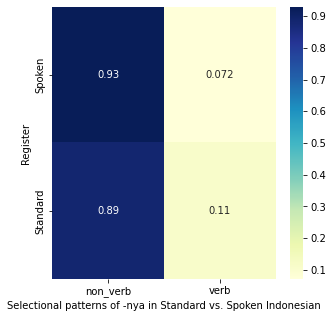

In [94]:
plt.figure(figsize=(5,5)) 
sns.heatmap(contigency_spoken, annot=True, cmap="YlGnBu")
plt.xlabel('Selectional patterns of -nya in Standard vs. Spoken Indonesian')
plt.show()

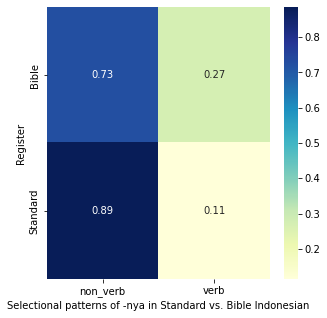

In [95]:
plt.figure(figsize=(5,5)) 
sns.heatmap(contigency_bible, annot=True, cmap="YlGnBu")
plt.xlabel('Selectional patterns of -nya in Standard vs. Bible Indonesian')
plt.show()

As the heatmaps clearly show, (i) **in Bible Indonesian, the particle *nya* attaches to verbs (= is used as a pronoun filling an argument position) much more often than in today's Standard Indonesian**! 

Moreover, (ii) **in spoken Indonesian, the particle *-nya* attaches to even less frequently than in today's Standard Indonesian**. 



#The statistical testing
But to be sure, we need to know whether the difference in numbers we just acquired is statistically significant. 
To to this, I have used the chi-squared test. We have two separate datasets, to which the chi-squared test will be applied independently.

We have the following hypotheses:

**Spoken Indonesian vs. Standard Indonesian**

H0: In Spoken Indonesian, the particle *-nya* attaches to the verbs as often as in today's Standard Indonesian.
H1: There is indeed the difference between the two kinds of language.

**Bible Indonesian vs. Standard Indonesian**:

H0: In "old" Bible Indonesian, the particle *-nya* attaches to the verbs as often as in today's Standard Indonesian.
H1: There is indeed the difference between the two kinds of language.

**Testing Spoken Indonesian vs. Standard Indonesian:**

In [128]:
st, p = chisquare([1084, 139], [1072, 84])
p

1.8305197745241353e-09

As we can see here, the p-value is far below the significance level (0.05). This means that we have to reject the null-hypothesis, and admit that, in Spoken Indonesian, the selectional patterns of *-nya* are indeed different from today's Standard Indonesian. 

**Testing Bible Indonesian vs. Standard Indonesian** :

In [132]:
st, p = chisquare([4555, 1715], [1072, 139])
p

0.0

Once again, the p-value is far lower than the significance lever. This means that, too, we have to reject the null hypothesis and admit that, in Bible Indonesian, the selectional patterns on *-nya* are different from today's Standard Indonesian.

# Results


*   In fact, in older varities of Indonesian, the particle *-nya* was used as a pronoun even more often (i.e. it attached to verbs more often)
*   In today's written Indonesian, the particle *-nya* is used pronominally more often than in today's spoken Indonesian
*... it appears that the particle *-nya* **is losing a "pronominal function", not acquiring it**
* the difference in frequencies between pronominal uses of *-nya* in "old" Indonesian and today's Standard Indonesian is statistically significant; the difference in frequencies between Spoken Indonesian and Standard Indonesian is significant as well




# P.S.
Похоже, выбор статистического теста был не самый удачный из-за очень боьших размеров выборов, а также разницы в размерах датасетов; вероятно, стоило бы использовать некоторый другой тест. 

Также в дальнейшем можно было бы улучшить парсер -- чтобы различать не только галголы и не-глаголы, но и другие части речи (например, имена). 

# References
Ogloblin, A. K. (2008). A Grammar of Literary Indonesian [Grammatika indoneziyskogo literaturnogo yazyka]. Saint-Petersburg University Press [Izdatelstvo Sankt- Peterburgskogo universiteta.].

Sneddon, J. N. (1996). Indonesian: a comprehensive grammar. Routledge.

Haspelmath, M. (1999). Why is grammaticalization irreversible?. Linguistics 37-6.